# Video tags extraction

This notebook's purpose is, for each decline, to extract some useful feature from the videos of the decline's channel, considering all videos during the decline and the last K videos before the decline, where K is the decline's duration.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

METADATA_FILENAME = 'data/yt_metadata_en.jsonl'

TO_FILE = 'data/videos_title_desc_around_declines.csv'

decline_events = pd.read_csv('data/sampled_decline_events.csv')

decline_events

,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Delta_videos,Views_start
0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.0,1.753062e+07
1,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,0.0,2.758465e+07
2,UCWmJyyUVP6AoR79IA9MTNpQ,30,False,192,222,People & Blogs,14676.662037,0,0.0,5.199927e+06
3,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,2.0,3.935174e+06
4,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,1.0,2.818956e+06
...,...,...,...,...,...,...,...,...,...,...
36594,UCFc1q8NjbBh_MHJvYP_sbsg,16,False,224,240,Education,75144.200000,0,0.0,2.834158e+07
36595,UCIPdIlv1EIGyTSfFAfV0Eag,10,True,236,246,Music,10360.125000,0,0.0,4.224860e+06
36596,UCHBjDnqvXPx8KcvgNQciRGg,17,False,223,240,Sports,151500.500000,0,0.0,5.123758e+06
36597,UCDmxnPem-pPfJQATIkfgY2Q,41,False,201,242,Education,117565.005208,0,0.0,3.964873e+07


In [2]:
channels = decline_events['Channel'].unique()

In [3]:
def map_column_to_week(df, column_name):
    """
    Replace the given column by a week index,
    starting from 0 in the earliest week found in the dataset

    Parameters:
    df  (pd.DataFrame): the dataframe in which to replace the week index
    column_name (str): the column to replace (must be a date: 'datetime' for timeseries, 'upload_date' for metadata)
    Return:
    df_week (pd.DataFrame): the dataframe with the week index
    """

    # The first date in the metadata is 2015-01-05, handle the time lag between the first date in metadata_helper and timeseries => keep only the data from 2015-01-05 (aligned with timeseries)
    first_date = pd.to_datetime('2015-01-05 00:00:00')

    # Get the first date in the dataset
    if column_name == 'upload_date':
        # Drop all raws with upload_date before 2015-01-05
        df = df[df['upload_date'] >= first_date]

    # Compute the week index
    df.loc[:,'week'] = df[column_name].apply(lambda x: (x - first_date).days // 7)

    df_week = df.drop(column_name, axis=1)

    # Remove the datetime column
    return df_week

In [4]:
# In batches of 5000 rows, extract the title, description, channel_id and week of the videos that are in the time frame for the respective channel
CHUNK_SIZE = 5000

pd.options.mode.chained_assignment = None # remove SettingWithCopyWarning: 

i = 0
for chunk in pd.read_json(METADATA_FILENAME, lines=True, chunksize=CHUNK_SIZE):

    try:
        init_shape = int(chunk.shape[0])
        
        chunk = chunk[chunk['channel_id'].isin(channels)]
        
        chunk.loc[:, 'upload_date'] = pd.to_datetime(chunk['upload_date'])

        chunk = map_column_to_week(chunk, 'upload_date')

        # keep the videos that are in the time frame for the respective channel
        mask = []
        for video in chunk.itertuples():
            channel_mask = decline_events['Channel'].isin([video.channel_id])
            start_mask = decline_events['Start'] - decline_events['Duration'] <= video.week
            end_mask = decline_events['End'] >= video.week

            mask.append(decline_events[channel_mask & start_mask & end_mask].shape[0] > 0)

        kept = chunk[mask]

        if kept.shape[0] == 0:
            print(f'Chunk {i} (lines {i*CHUNK_SIZE} to {(i+1)*CHUNK_SIZE}): 0/{init_shape} videos kept')
            i += 1
            continue

        cols_of_interest = ['channel_id', 'week', 'title', 'description']

        kept = kept[cols_of_interest]

        print(f'Chunk {i} (lines {i*CHUNK_SIZE} to {(i+1)*CHUNK_SIZE}): {kept.shape[0]}/{init_shape} videos kept')

        kept.to_csv(TO_FILE, index=False, mode='a', header=False) # Temporary filename

        i += 1
    
    except Exception as e:
        print(f'Error in chunk {i} (lines {i*CHUNK_SIZE} to {(i+1)*CHUNK_SIZE}): {e}')

Chunk 0 (lines 0 to 5000): 13/5000 videos kept
Chunk 1 (lines 5000 to 10000): 77/5000 videos kept
Chunk 2 (lines 10000 to 15000): 526/5000 videos kept
Chunk 3 (lines 15000 to 20000): 66/5000 videos kept
Chunk 4 (lines 20000 to 25000): 117/5000 videos kept
Chunk 5 (lines 25000 to 30000): 5/5000 videos kept
Chunk 6 (lines 30000 to 35000): 237/5000 videos kept
Chunk 7 (lines 35000 to 40000): 51/5000 videos kept
Chunk 8 (lines 40000 to 45000): 470/5000 videos kept
Chunk 9 (lines 45000 to 50000): 1/5000 videos kept
Chunk 10 (lines 50000 to 55000): 59/5000 videos kept
Chunk 11 (lines 55000 to 60000): 0/5000 videos kept
Chunk 12 (lines 60000 to 65000): 16/5000 videos kept
Chunk 13 (lines 65000 to 70000): 0/5000 videos kept
Chunk 14 (lines 70000 to 75000): 20/5000 videos kept
Chunk 15 (lines 75000 to 80000): 60/5000 videos kept
Chunk 16 (lines 80000 to 85000): 34/5000 videos kept
Chunk 17 (lines 85000 to 90000): 0/5000 videos kept
Chunk 18 (lines 90000 to 95000): 0/5000 videos kept
Chunk 19 (l

In [5]:
# print the length of METADATA_FILENAME
with open(METADATA_FILENAME) as f:
    print(f'Length of {METADATA_FILENAME}: {sum(1 for _ in f)}')

Length of data/yt_metadata_en.jsonl: 72924794


This matches the cell above. In total, around 1.9 million are extracted.

In [7]:
extracted_videos = pd.read_csv(TO_FILE, header=None)

extracted_videos.set_index([extracted_videos.columns[0], extracted_videos.columns[1]], inplace=True)
extracted_videos.index.names = ['channel', 'week']

extracted_videos

Game Reviewer Scam  \
channel                  week                                                      
UCzWm1-4XF7AHxVUTkHCM1uw 226               America's Retribution Term 2 Launched   
                         224                 America's Retribution Term 2 promo!   
                         224                    MTG Arena War of the Spark Day 1   
                         223                               Mpow Headphones Suck!   
                         222              Sekiro is the worst FromSoftware game.   
...                                                                          ...   
UCrwE8kVqtIUVUzKui2WVpuQ 109   Shri Manoj Kumar Tiwari's speech during Motion...   
                         109   Shri La Ganesan's speech during Motion of Than...   
                         109   Shri Mukhtar Abbas Naqvi's speech during Motio...   
                         109   BJP submitted complaint to EC against Chief Se...   
                         109   Shri Amit Shah speech at public meeting in Noi...   

                              America's Retribution Term 2 on Steam\nhttps://store.steampowered.com/app/1072350/Americas_Retribution_Term_2/\n\nFacebook https://www.facebook.com/RetroGamer3Page/\nTwitter http://twitter.com/usaretribution\n\n#indiedev #gamedev #indiegamedev  
channel                  week                                                                                                                                                                                                                                                      
UCzWm1-4XF7AHxVUTkHCM1uw 226   America's Retribution Term 2 on Steam\nhttps:/...                                                                                                                                                                                                   
                         224   America's Retribution Term 2 on Steam\nhttps:/...                                                                                                                                                                                                   
                         224   Play all my games at http://www.retrogamer3.co...                                                                                                                                                                                                   
                         223   Play all my games at http://www.retrogamer3.co...                                                                                                                                                                                                   
                         222   Play all my games at http://www.retrogamer3.co...                                                                                                                                                                                                   
...                                                                          ...                                                                                                                                                                                                   
UCrwE8kVqtIUVUzKui2WVpuQ 109   Shri Manoj Kumar Tiwari's speech during Motion...                                                                                                                                                                                                   
                         109   Shri La Ganesan's speech during Motion of Than...                                                                                                                                                                                                   
                         109   Shri Mukhtar Abbas Naqvi's speech during Motio...                                                                                                                                 

In [10]:
extracted_videos.to_csv(TO_FILE, index=True)

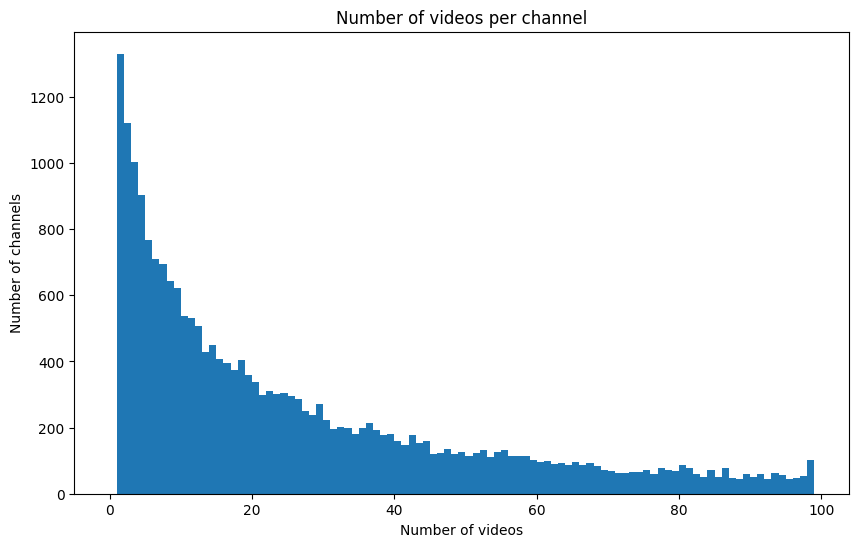

Number of channels: 27064
Number of channels without videos: 0


In [9]:
nb_videos = extracted_videos.groupby('channel').size()

plt.figure(figsize=(10, 6))

plt.hist(nb_videos.values, bins=range(0, 100))
plt.xlabel('Number of videos')
plt.ylabel('Number of channels')
plt.title('Number of videos per channel')
plt.show()

print(f'Number of channels: {extracted_videos.index.get_level_values(0).nunique()}')
print(f'Number of channels without videos: {len(nb_videos[nb_videos == 0])}')